<a href="https://colab.research.google.com/github/hila-chefer/Transformer-MM-Explainability/blob/main/Transformer_MM_Explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Generic Attention-model Explainability for Interpreting Bi-Modal and Encoder-Decoder Transformers (Transformer Multi Modal Explainability)**

In [1]:
#!git clone https://github.com/hila-chefer/Transformer-MM-Explainability

import os
os.chdir(f'./Transformer-MM-Explainability')

!pip install -r requirements.txt

fatal: destination path 'Transformer-MM-Explainability' already exists and is not an empty directory.


# **LXMERT**

**Examples from paper**

In [7]:
from lxmert.lxmert.src.modeling_frcnn import GeneralizedRCNN
import lxmert.lxmert.src.vqa_utils as utils
from lxmert.lxmert.src.processing_image import Preprocess
from transformers import LxmertTokenizer
from lxmert.lxmert.src.huggingface_lxmert import LxmertForQuestionAnswering


In [9]:
from lxmert.lxmert.src.modeling_frcnn import GeneralizedRCNN
import lxmert.lxmert.src.vqa_utils as utils
from lxmert.lxmert.src.processing_image import Preprocess
from transformers import LxmertTokenizer
from lxmert.lxmert.src.huggingface_lxmert import LxmertForQuestionAnswering
from lxmert.lxmert.src.lxmert_lrp import LxmertForQuestionAnswering as LxmertForQuestionAnsweringLRP
from tqdm import tqdm
from lxmert.lxmert.src.ExplanationGenerator import GeneratorOurs, GeneratorBaselines, GeneratorOursAblationNoAggregation
import random
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from captum.attr import visualization
import requests

In [10]:
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
VQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/vqa/trainval_label2ans.json"

In [11]:
class ModelUsage:
    def __init__(self, use_lrp=False):
        self.vqa_answers = utils.get_data(VQA_URL)

        # load models and model components
        self.frcnn_cfg = utils.Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
        self.frcnn_cfg.MODEL.DEVICE = "cuda"

        self.frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=self.frcnn_cfg)

        self.image_preprocess = Preprocess(self.frcnn_cfg)

        self.lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")

        if use_lrp:
            self.lxmert_vqa = LxmertForQuestionAnsweringLRP.from_pretrained("unc-nlp/lxmert-vqa-uncased").to("cuda")
        else:
            self.lxmert_vqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-vqa-uncased").to("cuda")

        self.lxmert_vqa.eval()
        self.model = self.lxmert_vqa

        # self.vqa_dataset = vqa_data.VQADataset(splits="valid")

    def forward(self, item):
        URL, question = item
        
        self.image_file_path = URL

        # run frcnn
        images, sizes, scales_yx = self.image_preprocess(URL)
        output_dict = self.frcnn(
            images,
            sizes,
            scales_yx=scales_yx,
            padding="max_detections",
            max_detections= self.frcnn_cfg.max_detections,
            return_tensors="pt"
        )
        inputs = self.lxmert_tokenizer(
            question,
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )
        self.question_tokens = self.lxmert_tokenizer.convert_ids_to_tokens(inputs.input_ids.flatten())
        self.text_len = len(self.question_tokens)
        # Very important that the boxes are normalized
        normalized_boxes = output_dict.get("normalized_boxes")
        features = output_dict.get("roi_features")
        self.image_boxes_len = features.shape[1]
        self.bboxes = output_dict.get("boxes")
        self.output = self.lxmert_vqa(
            input_ids=inputs.input_ids.to("cuda"),
            attention_mask=inputs.attention_mask.to("cuda"),
            visual_feats=features.to("cuda"),
            visual_pos=normalized_boxes.to("cuda"),
            token_type_ids=inputs.token_type_ids.to("cuda"),
            return_dict=True,
            output_attentions=False,
        )
        return self.output

In [12]:
def save_image_vis(image_file_path, bbox_scores):
    bbox_scores = image_scores
    _, top_bboxes_indices = bbox_scores.topk(k=1, dim=-1)
    img = cv2.imread(image_file_path)
    mask = torch.zeros(img.shape[0], img.shape[1])
    for index in range(len(bbox_scores)):
        [x, y, w, h] = model_lrp.bboxes[0][index]
        curr_score_tensor = mask[int(y):int(h), int(x):int(w)]
        new_score_tensor = torch.ones_like(curr_score_tensor)*bbox_scores[index].item()
        mask[int(y):int(h), int(x):int(w)] = torch.max(new_score_tensor,mask[int(y):int(h), int(x):int(w)])
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    mask = mask.unsqueeze_(-1)
    mask = mask.expand(img.shape)
    img = img * mask.cpu().data.numpy()
    cv2.imwrite(
            'lxmert/lxmert/experiments/paper/new.jpg', img)

In [13]:
model_lrp = ModelUsage(use_lrp=True)
lrp = GeneratorOurs(model_lrp)
baselines = GeneratorBaselines(model_lrp)
vqa_answers = utils.get_data(VQA_URL)

# baselines.generate_transformer_attr(None)
# baselines.generate_attn_gradcam(None)
# baselines.generate_partial_lrp(None)
# baselines.generate_raw_attn(None)
# baselines.generate_rollout(None)

image_ids = [
    # giraffe
    'COCO_val2014_000000185590',
    # baseball
    'COCO_val2014_000000127510',
    # bath
    'COCO_val2014_000000324266',
    # frisbee
    'COCO_val2014_000000200717'
]

test_questions_for_images = [
    ################## paper samples
    # giraffe
    "is the animal eating?",
    # baseball
    "did he catch the ball?",
    # bath
    "is the tub white ?",
    # frisbee
    "did the man just catch the frisbee?"
    ################## paper samples
]

%s not found in cache or force_download set to True, downloading to %s https://s3.amazonaws.com/models.huggingface.co/bert/unc-nlp/frcnn-vg-finetuned/config.yaml C:\Users\user\.cache\torch\transformers\tmp41qbr4ur


Downloading: 100%|██████████| 2.13k/2.13k [00:00<00:00, 11.5kB/s]


loading configuration file cache
%s not found in cache or force_download set to True, downloading to %s https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin C:\Users\user\.cache\torch\transformers\tmpe83nddyl


Downloading: 100%|██████████| 262M/262M [11:37<00:00, 376kB/s]    


loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at C:\Users\user/.cache\torch\transformers\57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


d:\Apps\miniconda\envs\llava\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


d:\Apps\miniconda\envs\llava\lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


ANSWER: no


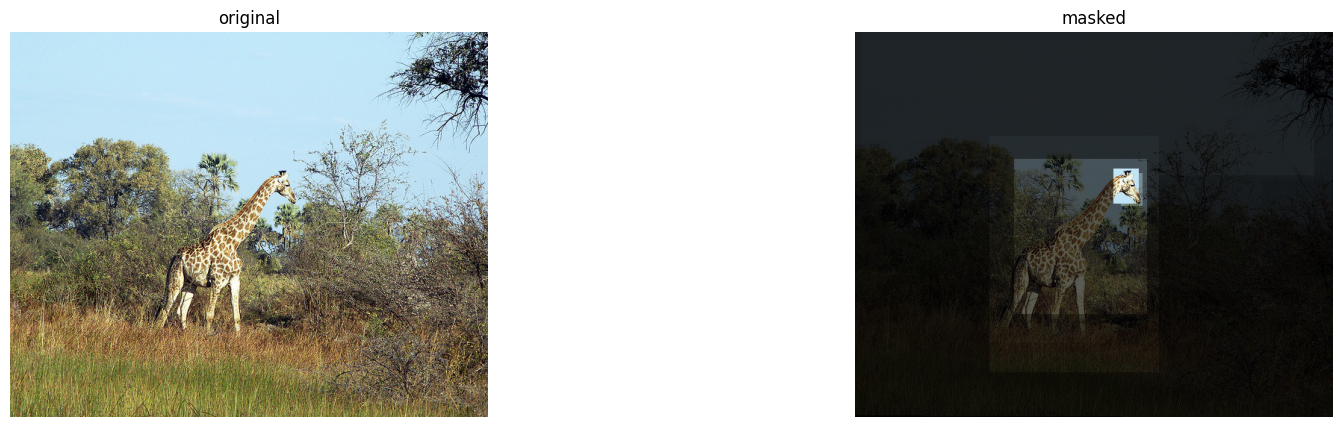

In [14]:
URL = 'lxmert/lxmert/experiments/paper/{0}/{0}.jpg'.format(image_ids[0])
R_t_t, R_t_i = lrp.generate_ours((URL, test_questions_for_images[0]), use_lrp=False, normalize_self_attention=True, method_name="ours")
image_scores = R_t_i[0]
text_scores = R_t_t[0]
save_image_vis(URL, image_scores)
orig_image = Image.open(model_lrp.image_file_path)

fig, axs = plt.subplots(ncols=2, figsize=(20, 5))
axs[0].imshow(orig_image)
axs[0].axis('off')
axs[0].set_title('original')

masked_image = Image.open('lxmert/lxmert/experiments/paper/new.jpg')
axs[1].imshow(masked_image)
axs[1].axis('off')
axs[1].set_title('masked')

text_scores = (text_scores - text_scores.min()) / (text_scores.max() - text_scores.min())
vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,model_lrp.question_tokens,1)]
visualization.visualize_text(vis_data_records)
print("ANSWER:", vqa_answers[model_lrp.output.question_answering_score.argmax()])

ANSWER: yes


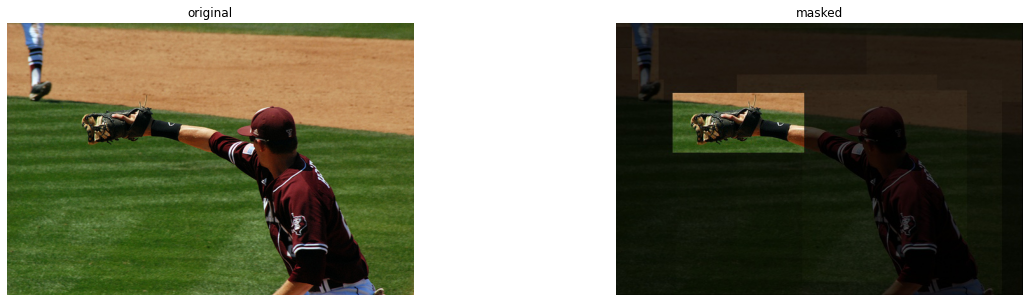

In [8]:
URL = 'lxmert/lxmert/experiments/paper/{0}/{0}.jpg'.format(image_ids[1])
R_t_t, R_t_i = lrp.generate_ours((URL, test_questions_for_images[1]), use_lrp=False, normalize_self_attention=True, method_name="ours")
image_scores = R_t_i[0]
text_scores = R_t_t[0]
save_image_vis(URL, image_scores)
orig_image = Image.open(model_lrp.image_file_path)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))
axs[0].imshow(orig_image);
axs[0].axis('off');
axs[0].set_title('original');

masked_image = Image.open('lxmert/lxmert/experiments/paper/new.jpg')
axs[1].imshow(masked_image);
axs[1].axis('off');
axs[1].set_title('masked');

text_scores = (text_scores - text_scores.min()) / (text_scores.max() - text_scores.min())
vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,model_lrp.question_tokens,1)]
visualization.visualize_text(vis_data_records)
print("ANSWER:", vqa_answers[model_lrp.output.question_answering_score.argmax()])

ANSWER: yes


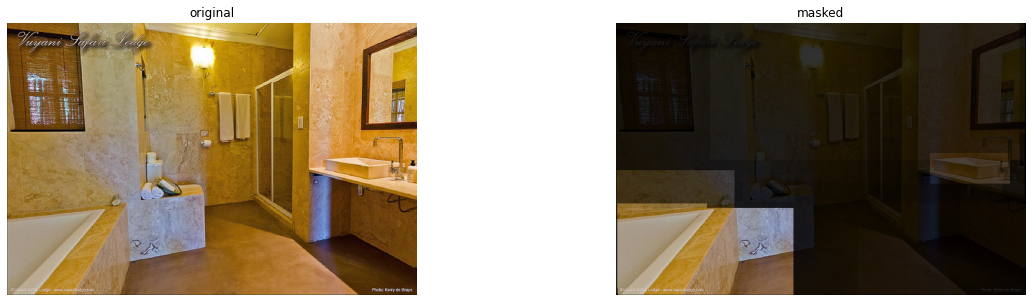

In [9]:
URL = 'lxmert/lxmert/experiments/paper/{0}/{0}.jpg'.format(image_ids[2])
R_t_t, R_t_i = lrp.generate_ours((URL, test_questions_for_images[2]), use_lrp=False, normalize_self_attention=True, method_name="ours")
image_scores = R_t_i[0]
text_scores = R_t_t[0]
save_image_vis(URL, image_scores)
orig_image = Image.open(model_lrp.image_file_path)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))
axs[0].imshow(orig_image);
axs[0].axis('off');
axs[0].set_title('original');

masked_image = Image.open('lxmert/lxmert/experiments/paper/new.jpg')
axs[1].imshow(masked_image);
axs[1].axis('off');
axs[1].set_title('masked');

text_scores = (text_scores - text_scores.min()) / (text_scores.max() - text_scores.min())
vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,model_lrp.question_tokens,1)]
visualization.visualize_text(vis_data_records)
print("ANSWER:", vqa_answers[model_lrp.output.question_answering_score.argmax()])

ANSWER: no


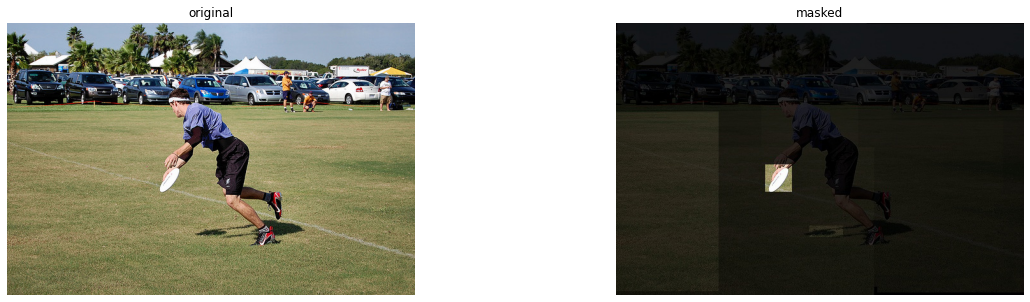

In [10]:
URL = 'lxmert/lxmert/experiments/paper/{0}/{0}.jpg'.format(image_ids[3])
R_t_t, R_t_i = lrp.generate_ours((URL, test_questions_for_images[3]), use_lrp=False, normalize_self_attention=True, method_name="ours")
image_scores = R_t_i[0]
text_scores = R_t_t[0]
save_image_vis(URL, image_scores)
orig_image = Image.open(model_lrp.image_file_path)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))
axs[0].imshow(orig_image);
axs[0].axis('off');
axs[0].set_title('original');

masked_image = Image.open('lxmert/lxmert/experiments/paper/new.jpg')
axs[1].imshow(masked_image);
axs[1].axis('off');
axs[1].set_title('masked');

text_scores = (text_scores - text_scores.min()) / (text_scores.max() - text_scores.min())
vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,model_lrp.question_tokens,1)]
visualization.visualize_text(vis_data_records)
print("ANSWER:", vqa_answers[model_lrp.output.question_answering_score.argmax()])

# **Online Examples**

To upload your own example, simply modify the URL to your image url, and the question to your question.

ANSWER: in hand


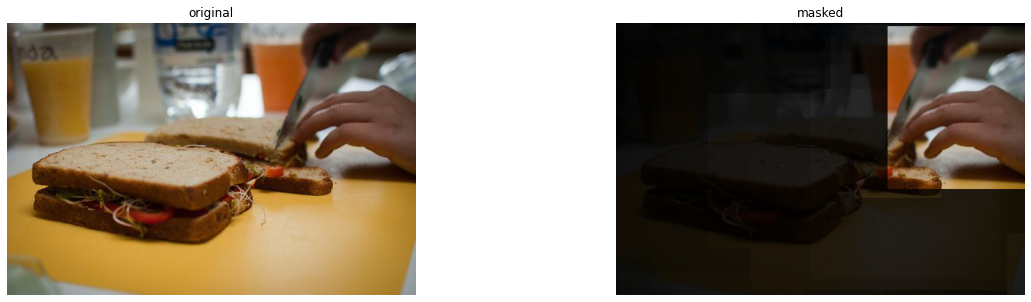

In [11]:
URL = "https://vqa.cloudcv.org/media/val2014/COCO_val2014_000000549112.jpg"

question =  'where is the knife?'

# save image to experiments folder
im = Image.open(requests.get(URL, stream=True).raw)
im.save('lxmert/lxmert/experiments/paper/online_image.jpg', 'JPEG')
URL = 'lxmert/lxmert/experiments/paper/online_image.jpg'

R_t_t, R_t_i = lrp.generate_ours((URL, question), use_lrp=False, normalize_self_attention=True, method_name="ours")
image_scores = R_t_i[0]
text_scores = R_t_t[0]
save_image_vis(URL, image_scores)
orig_image = Image.open(model_lrp.image_file_path)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))
axs[0].imshow(orig_image);
axs[0].axis('off');
axs[0].set_title('original');

masked_image = Image.open('lxmert/lxmert/experiments/paper/new.jpg')
axs[1].imshow(masked_image);
axs[1].axis('off');
axs[1].set_title('masked');

text_scores = (text_scores - text_scores.min()) / (text_scores.max() - text_scores.min())
vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,model_lrp.question_tokens,1)]
visualization.visualize_text(vis_data_records)
print("ANSWER:", vqa_answers[model_lrp.output.question_answering_score.argmax()])

ANSWER: 1


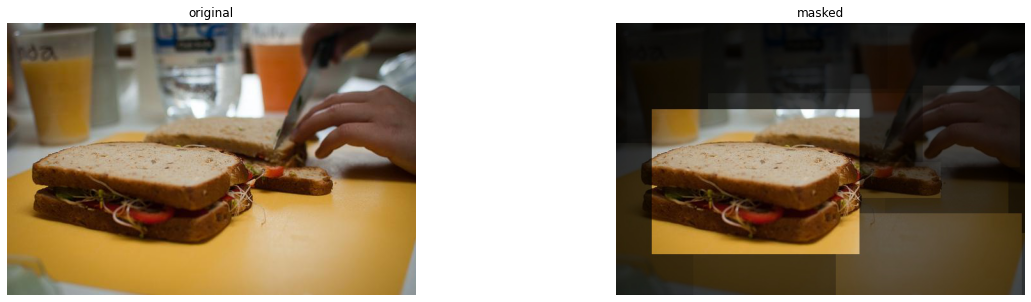

In [12]:
URL = "https://vqa.cloudcv.org/media/val2014/COCO_val2014_000000549112.jpg"

question =  'how many sandwiches?'

# save image to experiments folder
im = Image.open(requests.get(URL, stream=True).raw)
im.save('lxmert/lxmert/experiments/paper/online_image.jpg', 'JPEG')
URL = 'lxmert/lxmert/experiments/paper/online_image.jpg'

R_t_t, R_t_i = lrp.generate_ours((URL, question), use_lrp=False, normalize_self_attention=True, method_name="ours")
image_scores = R_t_i[0]
text_scores = R_t_t[0]
save_image_vis(URL, image_scores)
orig_image = Image.open(model_lrp.image_file_path)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))
axs[0].imshow(orig_image);
axs[0].axis('off');
axs[0].set_title('original');

masked_image = Image.open('lxmert/lxmert/experiments/paper/new.jpg')
axs[1].imshow(masked_image);
axs[1].axis('off');
axs[1].set_title('masked');

text_scores = (text_scores - text_scores.min()) / (text_scores.max() - text_scores.min())
vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,model_lrp.question_tokens,1)]
visualization.visualize_text(vis_data_records)
print("ANSWER:", vqa_answers[model_lrp.output.question_answering_score.argmax()])

ANSWER: plastic


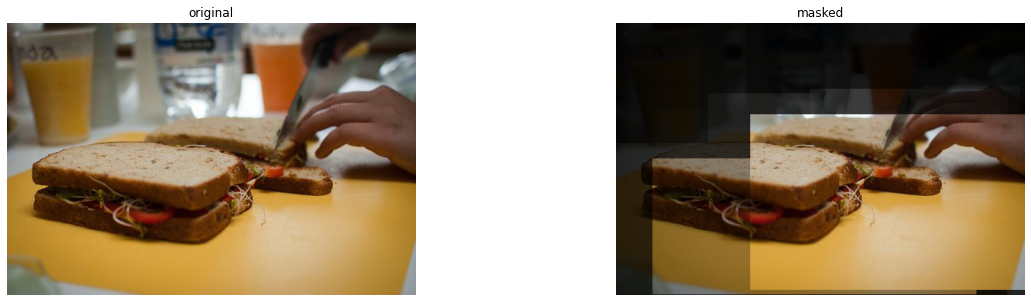

In [13]:
URL = "https://vqa.cloudcv.org/media/val2014/COCO_val2014_000000549112.jpg"

question =  'what is the surface made of?'

# save image to experiments folder
im = Image.open(requests.get(URL, stream=True).raw)
im.save('lxmert/lxmert/experiments/paper/online_image.jpg', 'JPEG')
URL = 'lxmert/lxmert/experiments/paper/online_image.jpg'

R_t_t, R_t_i = lrp.generate_ours((URL, question), use_lrp=False, normalize_self_attention=True, method_name="ours")
image_scores = R_t_i[0]
text_scores = R_t_t[0]
save_image_vis(URL, image_scores)
orig_image = Image.open(model_lrp.image_file_path)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))
axs[0].imshow(orig_image);
axs[0].axis('off');
axs[0].set_title('original');

masked_image = Image.open('lxmert/lxmert/experiments/paper/new.jpg')
axs[1].imshow(masked_image);
axs[1].axis('off');
axs[1].set_title('masked');

text_scores = (text_scores - text_scores.min()) / (text_scores.max() - text_scores.min())
vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,model_lrp.question_tokens,1)]
visualization.visualize_text(vis_data_records)
print("ANSWER:", vqa_answers[model_lrp.output.question_answering_score.argmax()])

ANSWER: yes


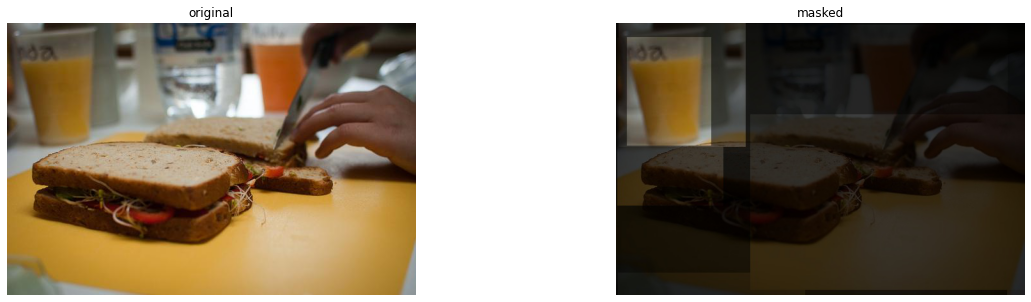

In [14]:
URL = "https://vqa.cloudcv.org/media/val2014/COCO_val2014_000000549112.jpg"

question =  'are there any cups?'

# save image to experiments folder
im = Image.open(requests.get(URL, stream=True).raw)
im.save('lxmert/lxmert/experiments/paper/online_image.jpg', 'JPEG')
URL = 'lxmert/lxmert/experiments/paper/online_image.jpg'

R_t_t, R_t_i = lrp.generate_ours((URL, question), use_lrp=False, normalize_self_attention=True, method_name="ours")
image_scores = R_t_i[0]
text_scores = R_t_t[0]
save_image_vis(URL, image_scores)
orig_image = Image.open(model_lrp.image_file_path)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))
axs[0].imshow(orig_image);
axs[0].axis('off');
axs[0].set_title('original');

masked_image = Image.open('lxmert/lxmert/experiments/paper/new.jpg')
axs[1].imshow(masked_image);
axs[1].axis('off');
axs[1].set_title('masked');

text_scores = (text_scores - text_scores.min()) / (text_scores.max() - text_scores.min())
vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,model_lrp.question_tokens,1)]
visualization.visualize_text(vis_data_records)
print("ANSWER:", vqa_answers[model_lrp.output.question_answering_score.argmax()])

ANSWER: 2


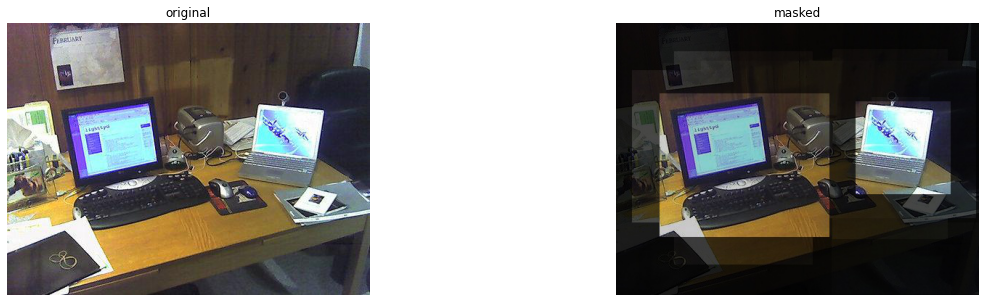

In [15]:
URL = "https://vqa.cloudcv.org/media/val2014/COCO_val2014_000000253263.jpg"

question =  'how many computers?'

# save image to experiments folder
im = Image.open(requests.get(URL, stream=True).raw)
im.save('lxmert/lxmert/experiments/paper/online_image.jpg', 'JPEG')
URL = 'lxmert/lxmert/experiments/paper/online_image.jpg'

R_t_t, R_t_i = lrp.generate_ours((URL, question), use_lrp=False, normalize_self_attention=True, method_name="ours")
image_scores = R_t_i[0]
text_scores = R_t_t[0]
save_image_vis(URL, image_scores)
orig_image = Image.open(model_lrp.image_file_path)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))
axs[0].imshow(orig_image);
axs[0].axis('off');
axs[0].set_title('original');

masked_image = Image.open('lxmert/lxmert/experiments/paper/new.jpg')
axs[1].imshow(masked_image);
axs[1].axis('off');
axs[1].set_title('masked');

text_scores = (text_scores - text_scores.min()) / (text_scores.max() - text_scores.min())
vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,model_lrp.question_tokens,1)]
visualization.visualize_text(vis_data_records)
print("ANSWER:", vqa_answers[model_lrp.output.question_answering_score.argmax()])

ANSWER: desk


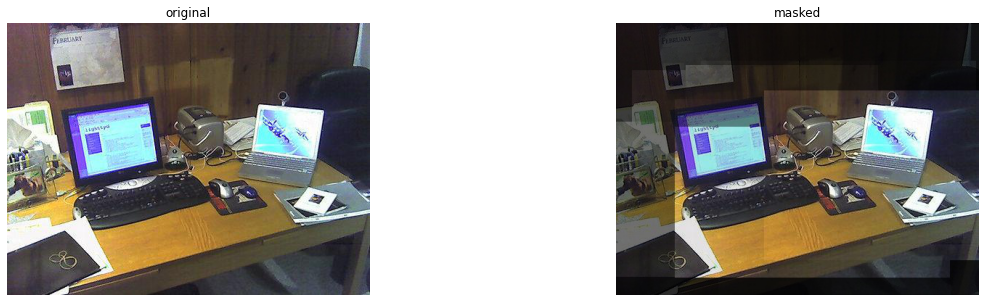

In [16]:
URL = "https://vqa.cloudcv.org/media/val2014/COCO_val2014_000000253263.jpg"

question =  'what is the computer on?'

# save image to experiments folder
im = Image.open(requests.get(URL, stream=True).raw)
im.save('lxmert/lxmert/experiments/paper/online_image.jpg', 'JPEG')
URL = 'lxmert/lxmert/experiments/paper/online_image.jpg'

R_t_t, R_t_i = lrp.generate_ours((URL, question), use_lrp=False, normalize_self_attention=True, method_name="ours")
image_scores = R_t_i[0]
text_scores = R_t_t[0]
save_image_vis(URL, image_scores)
orig_image = Image.open(model_lrp.image_file_path)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))
axs[0].imshow(orig_image);
axs[0].axis('off');
axs[0].set_title('original');

masked_image = Image.open('lxmert/lxmert/experiments/paper/new.jpg')
axs[1].imshow(masked_image);
axs[1].axis('off');
axs[1].set_title('masked');

text_scores = (text_scores - text_scores.min()) / (text_scores.max() - text_scores.min())
vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,model_lrp.question_tokens,1)]
visualization.visualize_text(vis_data_records)
print("ANSWER:", vqa_answers[model_lrp.output.question_answering_score.argmax()])

ANSWER: on wall


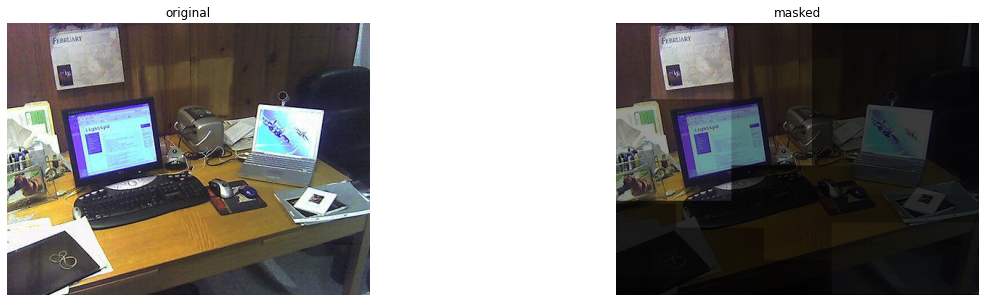

In [17]:
URL = "https://vqa.cloudcv.org/media/val2014/COCO_val2014_000000253263.jpg"

question =  'where is the calander?'

# save image to experiments folder
im = Image.open(requests.get(URL, stream=True).raw)
im.save('lxmert/lxmert/experiments/paper/online_image.jpg', 'JPEG')
URL = 'lxmert/lxmert/experiments/paper/online_image.jpg'

R_t_t, R_t_i = lrp.generate_ours((URL, question), use_lrp=False, normalize_self_attention=True, method_name="ours")
image_scores = R_t_i[0]
text_scores = R_t_t[0]
save_image_vis(URL, image_scores)
orig_image = Image.open(model_lrp.image_file_path)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))
axs[0].imshow(orig_image);
axs[0].axis('off');
axs[0].set_title('original');

masked_image = Image.open('lxmert/lxmert/experiments/paper/new.jpg')
axs[1].imshow(masked_image);
axs[1].axis('off');
axs[1].set_title('masked');

text_scores = (text_scores - text_scores.min()) / (text_scores.max() - text_scores.min())
vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,model_lrp.question_tokens,1)]
visualization.visualize_text(vis_data_records)
print("ANSWER:", vqa_answers[model_lrp.output.question_answering_score.argmax()])

ANSWER: computers


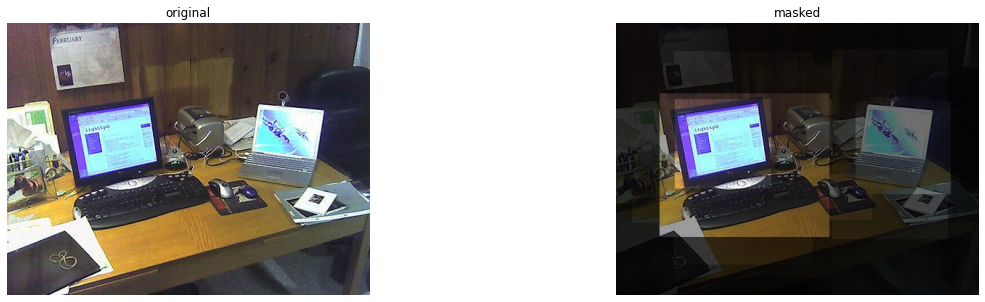

In [18]:
URL = "https://vqa.cloudcv.org/media/val2014/COCO_val2014_000000253263.jpg"

question =  'what is on the desk?'

# save image to experiments folder
im = Image.open(requests.get(URL, stream=True).raw)
im.save('lxmert/lxmert/experiments/paper/online_image.jpg', 'JPEG')
URL = 'lxmert/lxmert/experiments/paper/online_image.jpg'

R_t_t, R_t_i = lrp.generate_ours((URL, question), use_lrp=False, normalize_self_attention=True, method_name="ours")
image_scores = R_t_i[0]
text_scores = R_t_t[0]
save_image_vis(URL, image_scores)
orig_image = Image.open(model_lrp.image_file_path)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))
axs[0].imshow(orig_image);
axs[0].axis('off');
axs[0].set_title('original');

masked_image = Image.open('lxmert/lxmert/experiments/paper/new.jpg')
axs[1].imshow(masked_image);
axs[1].axis('off');
axs[1].set_title('masked');

text_scores = (text_scores - text_scores.min()) / (text_scores.max() - text_scores.min())
vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,model_lrp.question_tokens,1)]
visualization.visualize_text(vis_data_records)
print("ANSWER:", vqa_answers[model_lrp.output.question_answering_score.argmax()])

# **DETR**

In [19]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np

# from DETR.datasets.coco import *
import torch
import torchvision.transforms as T
import os
import random
import cv2
import DETR.util.misc as utils
from DETR.models import build_model
from DETR.modules.ExplanationGenerator import Generator
import argparse

Auxilary functions

In [20]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [22]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]


# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [23]:
device = 'cuda'
args = Namespace(aux_loss=True, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path=None, dataset_file='coco', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=300, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_queries=100, num_workers=2, output_dir='', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=1)
model, criterion, postprocessors = build_model(args)
model.to(device)
checkpoint = torch.hub.load_state_dict_from_url(
            args.resume, map_location='cpu', check_hash=True)
model.load_state_dict(checkpoint['model'], strict=False)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


_IncompatibleKeys(missing_keys=[], unexpected_keys=['transformer.encoder.layers.0.self_attn.in_proj_weight', 'transformer.encoder.layers.0.self_attn.in_proj_bias', 'transformer.encoder.layers.1.self_attn.in_proj_weight', 'transformer.encoder.layers.1.self_attn.in_proj_bias', 'transformer.encoder.layers.2.self_attn.in_proj_weight', 'transformer.encoder.layers.2.self_attn.in_proj_bias', 'transformer.encoder.layers.3.self_attn.in_proj_weight', 'transformer.encoder.layers.3.self_attn.in_proj_bias', 'transformer.encoder.layers.4.self_attn.in_proj_weight', 'transformer.encoder.layers.4.self_attn.in_proj_bias', 'transformer.encoder.layers.5.self_attn.in_proj_weight', 'transformer.encoder.layers.5.self_attn.in_proj_bias', 'transformer.decoder.layers.0.self_attn.in_proj_weight', 'transformer.decoder.layers.0.self_attn.in_proj_bias', 'transformer.decoder.layers.0.multihead_attn.in_proj_weight', 'transformer.decoder.layers.0.multihead_attn.in_proj_bias', 'transformer.decoder.layers.1.self_attn.in

In [24]:
def evaluate(model, gen, im, device, image_id = None):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0).to(device)

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.9

    if keep.nonzero().shape[0] <= 1:
        return

    outputs['pred_boxes'] = outputs['pred_boxes'].cpu()

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

    # use lists to store the outputs via up-values
    conv_features, enc_attn_weights, dec_attn_weights = [], [], []

    hooks = [
        model.backbone[-2].register_forward_hook(
            lambda self, input, output: conv_features.append(output)
        ),
        # model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        #     lambda self, input, output: enc_attn_weights.append(output[1])
        # ),
        model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
            lambda self, input, output: dec_attn_weights.append(output[1])
        ),
    ]

    for layer in model.transformer.encoder.layers:
        hook = layer.self_attn.register_forward_hook(
            lambda self, input, output: enc_attn_weights.append(output[1])
        )
        hooks.append(hook)

    model(img)

    for hook in hooks:
        hook.remove()

    # don't need the list anymore
    conv_features = conv_features[0]
    enc_attn_weights = enc_attn_weights[-1]
    dec_attn_weights = dec_attn_weights[0]

    # get the feature map shape
    h, w = conv_features['0'].tensors.shape[-2:]
    img_np = np.array(im).astype(np.float)


    fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22, 7))
    for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
        ax = ax_i[0]
        cam = gen.generate_ours(img, idx, use_lrp=False)
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        cmap = plt.cm.get_cmap('Blues').reversed()
        ax.imshow(cam.view(h, w).data.cpu().numpy(), cmap=cmap)
        ax.axis('off')
        ax.set_title(f'query id: {idx.item()}')
        ax = ax_i[1]
        ax.imshow(im)
        ax.add_patch(plt.Rectangle((xmin.detach(), ymin.detach()), xmax.detach() - xmin.detach(), ymax.detach() - ymin.detach(),
                                   fill=False, color='blue', linewidth=3))
        ax.axis('off')
        ax.set_title(CLASSES[probas[idx].argmax()])
    id_str = '' if image_id == None else image_id
    fig.tight_layout()
    plt.show()

**Paper examples**

In [25]:
gen = Generator(model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  if sys.path[0] == '':


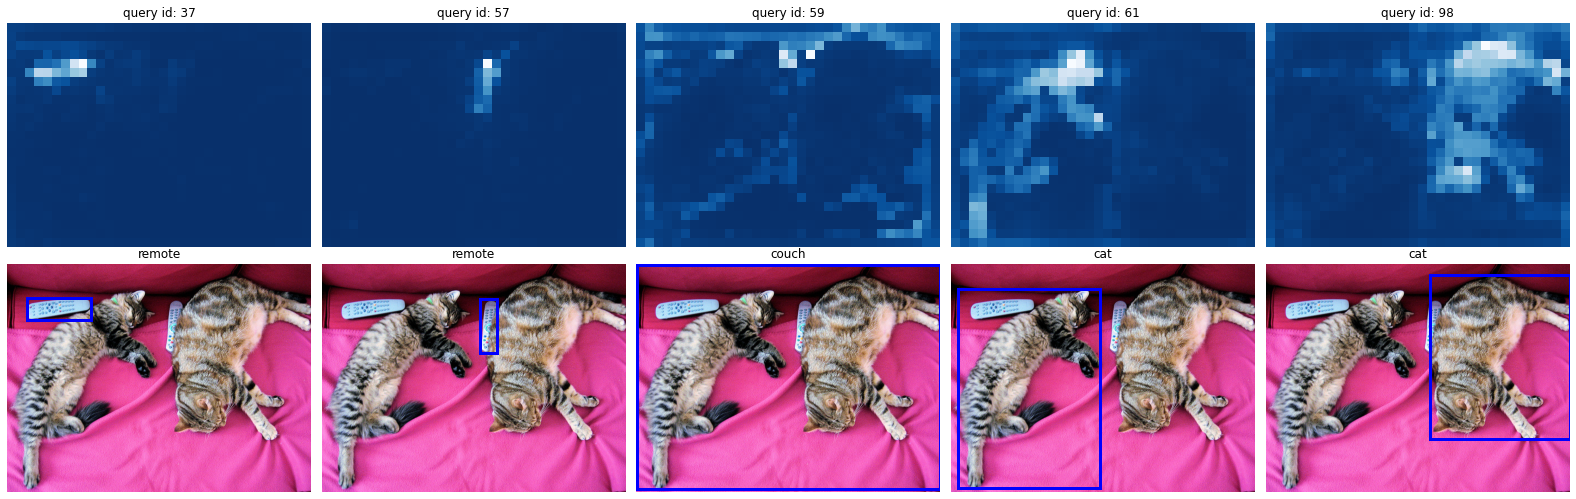

In [26]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)

evaluate(model, gen, im, 'cuda')

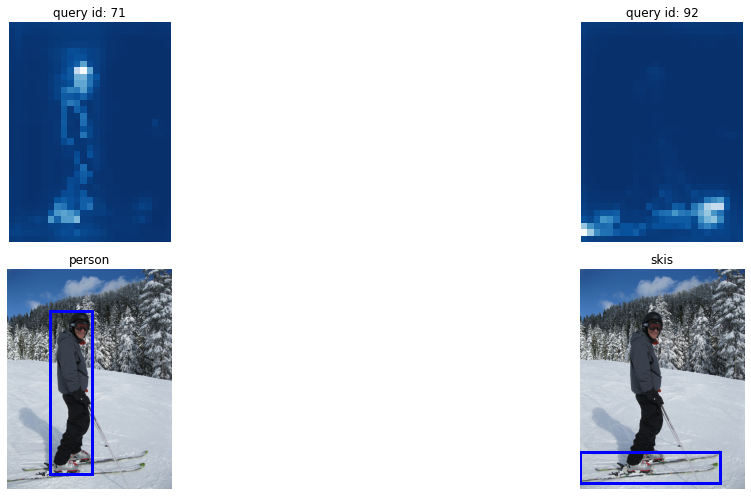

In [27]:
url = 'http://images.cocodataset.org/val2017/000000216516.jpg'
im = Image.open(requests.get(url, stream=True).raw)

evaluate(model, gen, im, 'cuda')

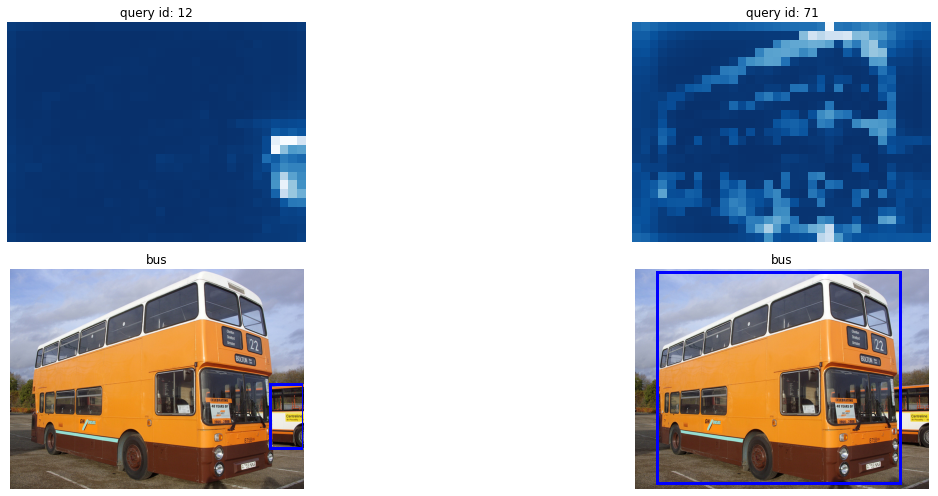

In [28]:

url = 'http://images.cocodataset.org/val2017/000000359937.jpg'
im = Image.open(requests.get(url, stream=True).raw)

evaluate(model, gen, im, 'cuda')

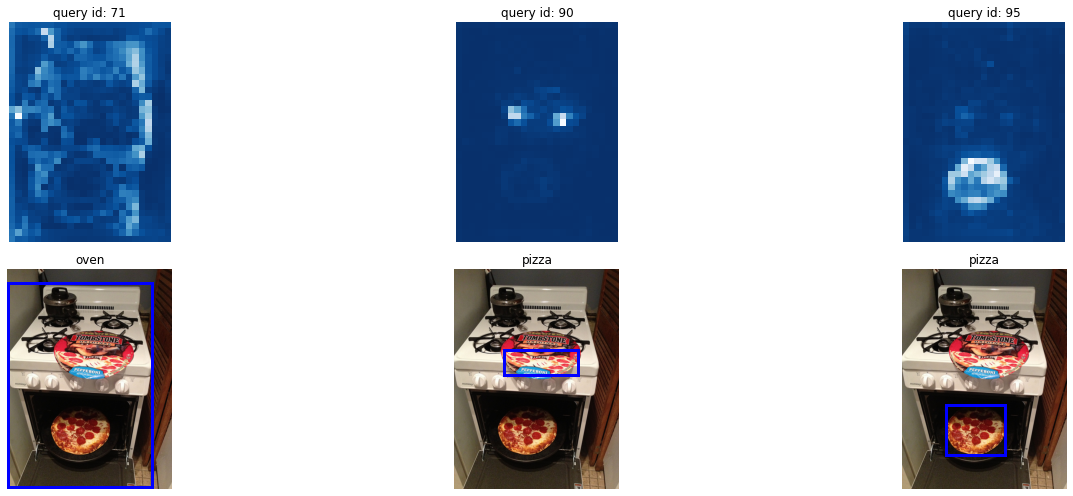

In [29]:
url = 'http://images.cocodataset.org/val2017/000000192191.jpg'
im = Image.open(requests.get(url, stream=True).raw)

evaluate(model, gen, im, 'cuda')